# Jump to the `Distillation` header to skip seminar code

# Import and misc

In [7]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence
import torchaudio
from IPython import display as display_
from matplotlib import pyplot as plt

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [4]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 32
    attention_size: int = 32
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

In [5]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keyword': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [6]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [7]:
dataset.csv.sample(5)

,path,keyword,label
33370,speech_commands/five/d197e3ae_nohash_4.wav,five,0
40781,speech_commands/left/be7a5b2d_nohash_1.wav,left,0
35277,speech_commands/two/0e5193e6_nohash_1.wav,two,0
48596,speech_commands/four/3e2ba5f7_nohash_2.wav,four,0
23105,speech_commands/one/f810e799_nohash_1.wav,one,0


In [11]:
from IPython.display import Audio

In [9]:
Audio('speech_commands/_background_noise_/dude_miaowing.wav')

### Augmentations

In [10]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [11]:
torch.manual_seed(42424242)
indexes = torch.randperm(len(dataset), )
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [12]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [13]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [14]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [15]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [16]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [17]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [18]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [19]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [20]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [21]:
class Attention(nn.Module):

    def __init__(self, input_size:int, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)
    
    def forward_energy(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2), energy
    
class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size, config.attention_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output
    
    def forward_attention(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector, attention = self.attention.forward_energy(gru_output)
        output = self.classifier(contex_vector)
        return output, attention

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

In [22]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        # FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [23]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [24]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

# Training

In [29]:
history = defaultdict(list)
config = TaskConfig(hidden_size=32, attention_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [26]:
sum([p.numel() for p in model.parameters()])

25387

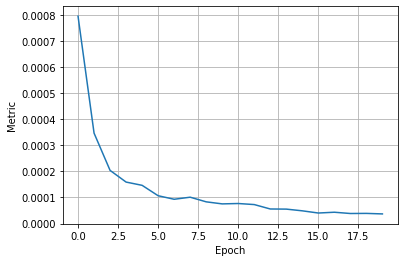

END OF EPOCH 19


In [30]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    acc = train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)
    history["acc"].append(acc.item())

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [31]:
history

defaultdict(list,
            {'val_metric': [0.0007946923438303988,
              0.0003464668612385556,
              0.00020360675592029205,
              0.0001588322464191358,
              0.00014634813687942913,
              0.00010646701639479265,
              9.29087482904841e-05,
              0.00010084558657337599,
              8.306229478163325e-05,
              7.520303461729596e-05,
              7.662927848918404e-05,
              7.259521632434576e-05,
              5.565334874154119e-05,
              5.516997738747033e-05,
              4.859373995307419e-05,
              4.017949786369256e-05,
              4.320504448732127e-05,
              3.832955811354483e-05,
              3.875325399180447e-05,
              3.674815800454757e-05],
             'acc': [0.71875,
              0.78125,
              0.8125,
              0.859375,
              0.875,
              0.828125,
              0.84375,
              0.875,
              0.609375,
            

In [32]:
!pip install thop

In [309]:
import tempfile
from thop import profile
import copy

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

def get_flops(model, sample):
    m = copy.deepcopy(model)
    return profile(m, (sample,), verbose=False)[0]

In [52]:
@dataclasses.dataclass
class StudentConfig:
    keyword: str = 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    temperature: float = 4.
    weight_decay: float = 1e-5
    num_epochs: int = 30
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 16
    attention_size: int = 32
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Distillation

In [35]:
def tempereature_softmax(input, temperature = 1, dimension=-1):
  input = input / temperature
  input = input.exp()
  return input / input.sum(dimension, keepdim=True)

def distillation_epoch(student, teacher, opt, loader, log_melspec, device, temperature):
    student.train()
    teacher.eval()
    losses = []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        student_logits = student(batch)
        with torch.no_grad():
          teacher_logits = teacher(batch)

        student_probs = tempereature_softmax(student_logits, temperature)
        teacher_probs = tempereature_softmax(teacher_logits, temperature)

        loss = F.kl_div(student_probs.log(), teacher_probs, reduction="batchmean")

        loss.backward()
        losses.append(loss.item())
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()

    return losses

## Attention Distillation

Let's check how the size of the hidden layer in the Attention module affects the quality of the model.

I keep other layers and their weights constant and distill a new Attention module with various hidden layer sizes.

In [73]:
def attention_distillation_epoch(student, teacher, opt, loader, log_melspec, device, temperature):
    student.train()
    teacher.eval()
    attention_divergences = []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        student_logits, student_attention = student.forward_attention(batch)
        with torch.no_grad():
          teacher_logits, teacher_attention = teacher.forward_attention(batch)

        student_attention = tempereature_softmax(student_attention, temperature, -2)
        teacher_attention = tempereature_softmax(teacher_attention, temperature, -2)
        attention_divergence =  F.kl_div(student_attention.log(), teacher_attention, reduction="batchmean")
        
        loss = attention_divergence
        
        loss.backward()
        attention_divergences.append(attention_divergence.item())
        
        torch.nn.utils.clip_grad_norm_(student.parameters(), 3)

        opt.step()

    return attention_divergences

In [121]:
attention_sizes = [31, 30, 29, 26, 24, 22, 20, 16, 8, 4, 2, 1]
attention_distillation_models = []
attention_distillation_histories = []

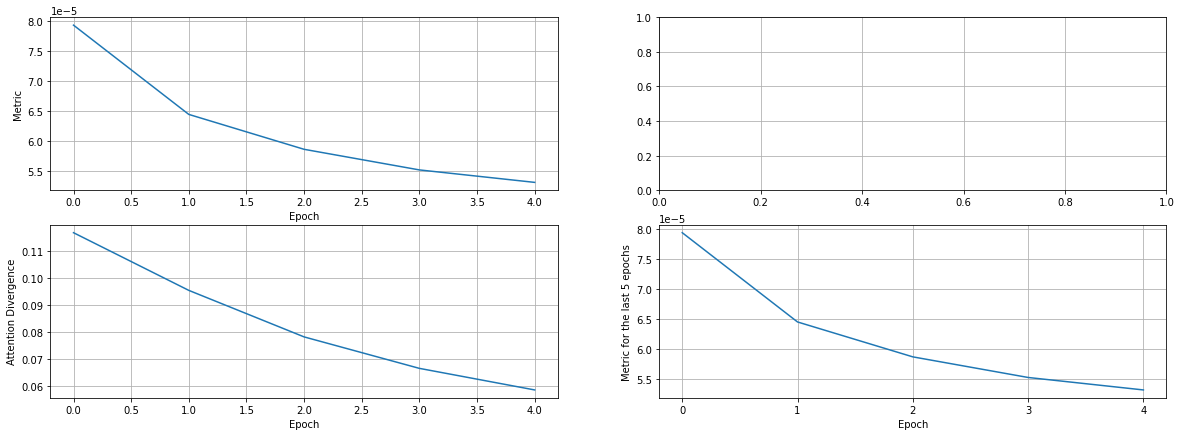

END OF EPOCH 4


In [122]:
for size in attention_sizes[7:]:
    distillation_history = defaultdict(list)
    student_config = StudentConfig(hidden_size=32, attention_size=size, num_epochs=5)
    student = CRNN(student_config).to(config.device)
    
    # load the weights of the teacher for everything but attention
    state = student.state_dict()
    for name, param_teacher in model.state_dict().items():
        if "attention" not in name:
            state[name] = param_teacher
    student.load_state_dict(state)
    
    # freeze everything but attention
    for name, param in student.named_parameters():
        if "attention" not in name:
            param.requires_grad_(False)

    print(student)

    opt = torch.optim.Adam(
        student.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    
    # fit
    for n in range(student_config.num_epochs):

        att_divergence = attention_distillation_epoch(student, model, opt, train_loader,
                    melspec_train, student_config.device, student_config.temperature)
        distillation_history["att_divergence"].append(sum(att_divergence)/len(att_divergence))

        au_fa_fr = validation(student, val_loader,
                              melspec_val, student_config.device)
        distillation_history['val_metric'].append(au_fa_fr)

        clear_output()
        _, axs = plt.subplots(2, 2, figsize=(20,7))
        axs = axs.flatten()
        axs[0].plot(distillation_history['val_metric'])
        axs[0].set_ylabel('Metric')
        axs[0].set_xlabel('Epoch')
    #     axs[1].plot(distillation_history['pred_divergence'])
    #     axs[1].set_ylabel('Prediction Divergence')
    #     axs[1].set_xlabel('Step')
        axs[2].plot(distillation_history['att_divergence'])
        axs[2].set_ylabel('Attention Divergence')
        axs[2].set_xlabel('Epoch')
        last_epochs = 5
        x = list(range(len(distillation_history['val_metric'])))[-last_epochs:]
        axs[3].plot(x, distillation_history['val_metric'][-last_epochs:])
        axs[3].set_ylabel(f'Metric for the last {len(x)} epochs')
        axs[3].set_xlabel('Epoch')
        axs[3].set_xticks(x)
        for ax in axs:
          ax.grid()
        plt.show()

        print('END OF EPOCH', n)
    
    attention_distillation_models.append(student.to(torch.device("cpu")))
    attention_distillation_histories.append(distillation_history)

In [123]:
model_sizes = []
metrics = []
flops = []
sample = torch.randn(1, 16_000*2).to("cuda")
sample = melspec_val(sample).to("cpu")
for m, h in zip(attention_distillation_models, attention_distillation_histories):
    model_sizes.append(get_size_in_megabytes(m))
    metrics.append(h["val_metric"][-1])
    flops.append(get_flops(m, sample))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops(

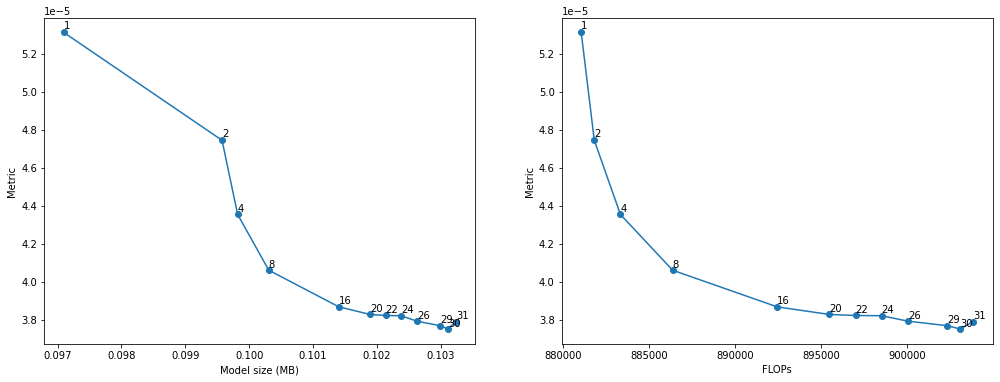

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
axs[0].plot(model_sizes, metrics)
axs[1].plot(flops, metrics)

axs[0].set_ylabel("Metric")
axs[1].set_ylabel("Metric")
axs[0].set_xlabel("Model size (MB)")
axs[1].set_xlabel("FLOPs")

axs[0].scatter(model_sizes, metrics)
axs[1].scatter(flops, metrics)

for i, txt in enumerate(attention_sizes):
    axs[0].annotate(txt, (model_sizes[i], metrics[i]*1.004))
for i, txt in enumerate(attention_sizes):
    axs[1].annotate(txt, (flops[i], metrics[i]*1.004))

As you can see, we can greatly decrease the size of the hidden layer.

## Dark Knowledge distillation

Let's vary the size of the model and distill the student with the baseline model

In [177]:
hidden_sizes = [24, 24]
cnn_channels = [6, 6]
gru_layers = [2, 1]

In [127]:
distillation_models = []
distillation_histories = []

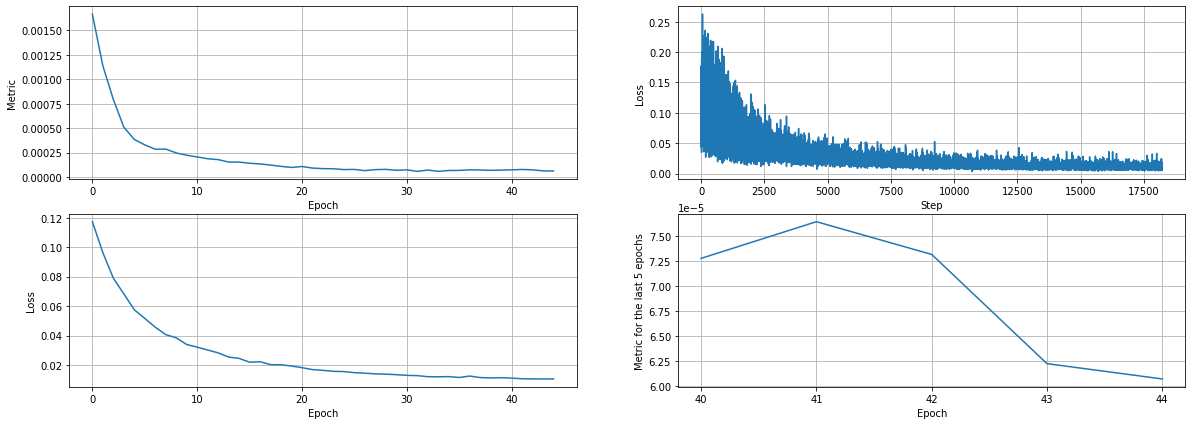

END OF EPOCH 44


In [153]:
for hidden, channels, gru in zip(hidden_sizes, cnn_channels, gru_layers):
    distillation_history = defaultdict(list)
    student_config = StudentConfig(hidden_size=hidden, attention_size=hidden, cnn_out_channels=channels,
                                   gru_num_layers=gru, learning_rate=3e-3,num_epochs=45)
    student = CRNN(student_config).to(config.device)
    
    print(student)

    opt = torch.optim.Adam(
        student.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    
    # fit
    for n in range(student_config.num_epochs):

        losses = distillation_epoch(student, model, opt, train_loader,
                    melspec_train, config.device, student_config.temperature)
        distillation_history["step_loss"].extend(losses)
        distillation_history["loss"].append(sum(losses)/len(losses))

        au_fa_fr = validation(student, val_loader,
                              melspec_val, config.device)
        distillation_history['val_metric'].append(au_fa_fr)

        clear_output()
        _, axs = plt.subplots(2, 2, figsize=(20,7))
        axs = axs.flatten()
        axs[0].plot(distillation_history['val_metric'])
        axs[0].set_ylabel('Metric')
        axs[0].set_xlabel('Epoch')
        axs[1].plot(distillation_history['step_loss'])
        axs[1].set_ylabel('Loss')
        axs[1].set_xlabel('Step')
        axs[2].plot(distillation_history['loss'])
        axs[2].set_ylabel('Loss')
        axs[2].set_xlabel('Epoch')
        last_epochs = 5
        x = list(range(len(distillation_history['val_metric'])))[-last_epochs:]
        axs[3].plot(x, distillation_history['val_metric'][-last_epochs:])
        axs[3].set_ylabel(f'Metric for the last {len(x)} epochs')
        axs[3].set_xlabel('Epoch')
        axs[3].set_xticks(x)
        for ax in axs:
          ax.grid()
        plt.show()

        print('END OF EPOCH', n)
    
    distillation_models.append(student.to(torch.device("cpu")))
    distillation_histories.append(distillation_history)

In [178]:
model_sizes = []
metrics = []
flops = []
sample = torch.randn(1, 16_000*2).to("cuda")
sample = melspec_val(sample).to("cpu")
for m, h in zip(distillation_models, distillation_histories):
    model_sizes.append(get_size_in_megabytes(m))
    metrics.append(h["val_metric"][-1])
    flops.append(get_flops(m, sample))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


In [179]:
# account for the baseline model
model_sizes = [get_size_in_megabytes(model)] + model_sizes
metrics = [validation(model, val_loader, melspec_val, config.device)] + metrics
flops = [get_flops(model, sample.to("cuda"))] + flops
hidden_sizes = [32] + hidden_sizes
cnn_channels = [8] + cnn_channels
gru_layers = [2] + gru_layers

102it [00:06, 16.12it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


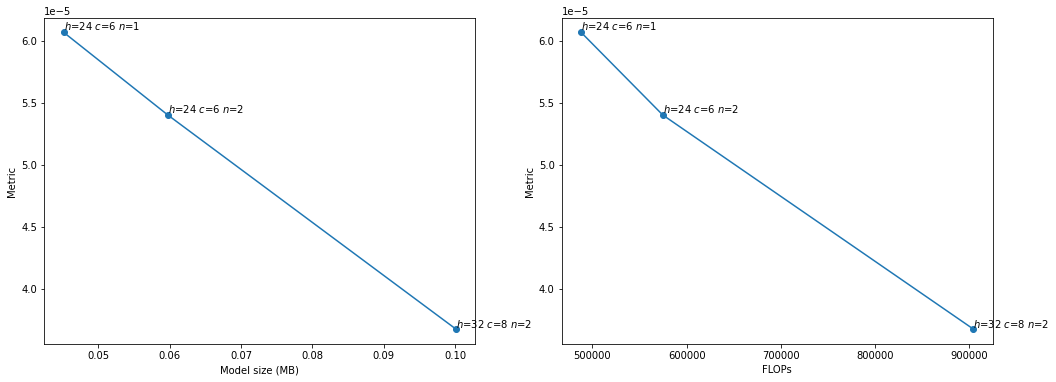

In [182]:
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
axs[0].plot(model_sizes, metrics)
axs[1].plot(flops, metrics)

axs[0].set_ylabel("Metric")
axs[1].set_ylabel("Metric")
axs[0].set_xlabel("Model size (MB)")
axs[1].set_xlabel("FLOPs")

axs[0].scatter(model_sizes, metrics)
axs[1].scatter(flops, metrics)

for i, hid in enumerate(hidden_sizes):
    axs[0].annotate(f"$h$={hid} $c$={cnn_channels[i]} $n$={gru_layers[i]}", (model_sizes[i], metrics[i]*1.004))
for i, hid in enumerate(hidden_sizes):
    axs[1].annotate(f"$h$={hid} $c$={cnn_channels[i]} $n$={gru_layers[i]}", (flops[i], metrics[i]*1.004))

The effect of reduction of other layers is much greater

## Final Distillation

Here I distill the smallest model I can get:

In [271]:
def distillation_with_attention_epoch(student, teacher, opt, loader, log_melspec, device, temperature, attention_prop=0.5):
    student.train()
    teacher.eval()
    prediction_divergences = []
    attention_divergences = []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        student_logits, student_attention = student.forward_attention(batch)
        with torch.no_grad():
          teacher_logits, teacher_attention = teacher.forward_attention(batch)

        student_attention = tempereature_softmax(student_attention, temperature, -2)
        teacher_attention = tempereature_softmax(teacher_attention, temperature, -2)
        
        student_probs = tempereature_softmax(student_logits, temperature)
        teacher_probs = tempereature_softmax(teacher_logits, temperature)

        prediction_divergence = F.kl_div(student_probs.log(), teacher_probs, reduction="batchmean")
        attention_divergence =  F.kl_div(student_attention.log(), teacher_attention, reduction="batchmean")
        
        loss = prediction_divergence + attention_prop * attention_divergence
        
        loss.backward()
        prediction_divergences.append(prediction_divergence.item())
        attention_divergences.append(attention_divergence.item())
        
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()

        # logging
        # argmax_probs = torch.argmax(student_probs, dim=-1)
        # FA, FR = count_FA_FR(argmax_probs, labels)
        # acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return prediction_divergences, attention_divergences

In [325]:
prev_student = student

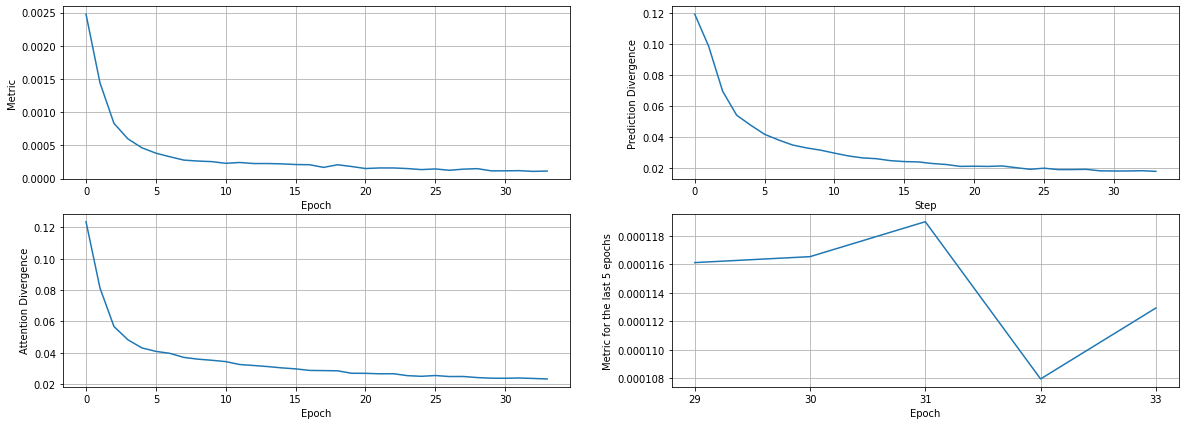

END OF EPOCH 33


100%|██████████| 405/405 [00:46<00:00,  8.72it/s]
0it [00:00, ?it/s]


training interrupted


In [332]:
distillation_history = defaultdict(list)
student_config = StudentConfig(num_epochs=60, gru_num_layers=1, cnn_out_channels=4, hidden_size=20, attention_size=10,
                               temperature=4., learning_rate=3e-4)
student = CRNN(student_config).to(config.device)

print(student)

opt = torch.optim.Adam(
    student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
print(sum([p.numel() for p in student.parameters()]))

try:
    for n in range(student_config.num_epochs):

        pred_divergence, att_divergence = distillation_with_attention_epoch(student, model, opt, train_loader,
                    melspec_train, student_config.device, student_config.temperature)
        distillation_history["att_divergence"].append(sum(att_divergence)/len(att_divergence))
        distillation_history["pred_divergence"].append(sum(pred_divergence)/len(pred_divergence))

        au_fa_fr = validation(student, val_loader,
                              melspec_val, student_config.device)
        distillation_history['val_metric'].append(au_fa_fr)

        clear_output()
        _, axs = plt.subplots(2, 2, figsize=(20,7))
        axs = axs.flatten()
        axs[0].plot(distillation_history['val_metric'])
        axs[0].set_ylabel('Metric')
        axs[0].set_xlabel('Epoch')
        axs[1].plot(distillation_history['pred_divergence'])
        axs[1].set_ylabel('Prediction Divergence')
        axs[1].set_xlabel('Step')
        axs[2].plot(distillation_history['att_divergence'])
        axs[2].set_ylabel('Attention Divergence')
        axs[2].set_xlabel('Epoch')
        last_epochs = 5
        x = list(range(len(distillation_history['val_metric'])))[-last_epochs:]
        axs[3].plot(x, distillation_history['val_metric'][-last_epochs:])
        axs[3].set_ylabel(f'Metric for the last {len(x)} epochs')
        axs[3].set_xlabel('Epoch')
        axs[3].set_xticks(x)
        for ax in axs:
          ax.grid()
        plt.show()

        print('END OF EPOCH', n)
except KeyboardInterrupt:
    print("training interrupted")

In [282]:
distillation_history

defaultdict(list,
            {'att_divergence': [0.12381772348358307,
              0.07510972666427677,
              0.053531887009739876,
              0.04769995742833909,
              0.04370443520630583,
              0.0393054322420079,
              0.03706746670750924,
              0.0347073451374416,
              0.03340323235333702,
              0.03158548955840093,
              0.03028024056535444,
              0.028145751961863336,
              0.02794183987526246,
              0.026904920336824876,
              0.02636467436397517,
              0.025000394418559693,
              0.02444671336101529,
              0.02403821296024102,
              0.02385043173936414,
              0.023290664136961653,
              0.022676418183578385,
              0.02183869947667843,
              0.02151949542724056,
              0.021078654378652573,
              0.02090309990087041,
              0.020620978425866292,
              0.01997309688616682,
             

In [280]:
au_fa_fr = validation(student, val_loader,
                              melspec_val, student_config.device)

102it [00:06, 16.54it/s]


In [281]:
au_fa_fr

4.894582526036037e-05

In [322]:
torch.save(student, "student_attention_fin_1.pth")

In [284]:
model_size = get_size_in_megabytes(model)
student_size = get_size_in_megabytes(student)
model_size, student_size, model_size / student_size

(0.10010814666748047, 0.02717113494873047, 3.6843564634445967)

In [290]:
model_flops = get_flops(model.to("cpu"), sample)
student_flops = get_flops(student.to("cpu"), sample)
model_size = get_size_in_megabytes(model)
student_size = get_size_in_megabytes(student)
model_size, student_size, model_size / student_size, model_flops / student_flops

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


(0.10112476348876953,
 0.027466773986816406,
 3.681712440540259,
 2.981470617316502)

In [299]:
print(f"""The compresstion rate is: {round(model_size / student_size, 1)}\n
The speed-up rate is: {round(model_flops / student_flops, 1)}""")

The compresstion rate is: 3.7

The speed-up rate is: 3.0


In [323]:
torch.save(quantized_student, "quantized_student.pt")

# Quantization

In [186]:
import torch.quantization

In [196]:
cpu_melspec_val = LogMelspec(is_train=False, config=TaskConfig(device=torch.device("cpu")))

In [266]:
quantizations = [{nn.Linear}, {nn.GRU}, {nn.Linear, nn.GRU}]

In [267]:
metrics = []
model_sizes = []
for q in quantizations:
    quantized_model = torch.quantization.quantize_dynamic(model.to("cpu"), q, dtype=torch.qint8)
    metrics.append(validation(quantized_model, val_loader, cpu_melspec_val, torch.device("cpu")))
    model_sizes.append(get_size_in_megabytes(quantized_model))

102it [00:09, 10.32it/s]
102it [00:11,  9.26it/s]
102it [00:14,  7.04it/s]


In [268]:
# account for baseline
metrics.append(validation(model.to("cpu"), val_loader, cpu_melspec_val, torch.device("cpu")))
model_sizes.append(get_size_in_megabytes(model))
quantizations.append(None)

102it [00:08, 11.35it/s]


In [269]:
quantizations, metrics, model_sizes = zip(*sorted(list(zip(quantizations, metrics, model_sizes)), key=lambda v: v[2]))

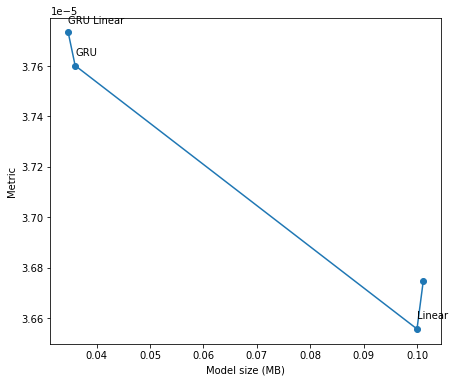

In [270]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.plot(model_sizes, metrics)

ax.set_ylabel("Metric")
ax.set_xlabel("Model size (MB)")

ax.scatter(model_sizes, metrics)

for i, q in enumerate(quantizations):
    text = " ".join([c.__name__ for c in q]) if q else " "
    ax.annotate(text, (model_sizes[i], metrics[i]+7e-8*random.random()))

Quantization reduces the size of the model greatly without affecting the quality too much.

# Final Model

In [312]:
quantized_student = torch.quantization.quantize_dynamic(student.to("cpu"), q, dtype=torch.qint8)
metric = (validation(quantized_student, val_loader, cpu_melspec_val, torch.device("cpu")))
quantized_student_size = (get_size_in_megabytes(quantized_student))
quantized_student_flops = get_flops(quantized_student, sample)

/opt/conda/lib/python3.7/site-packages/torch/nn/quantized/dynamic/modules/rnn.py:64: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
102it [00:09, 10.25it/s]


In [313]:
metric

5.077487859397418e-05

In [316]:
print(f"""The compresstion rate is: {round(model_size / quantized_student_size, 1)}\n
The speed-up rate is: {round(model_flops / student_flops, 1)}""")

The compresstion rate is: 7.6

The speed-up rate is: 3.0


# Streaming

In [319]:
class InferenceKWS(nn.Module):
    def __init__(self, model, device=torch.device("cpu")):
        super().__init__()
        self.model = model.to(device)
        self.gru_hidden = None
        self.encoder_cache = None
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
                sample_rate=model.config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=model.config.n_mels
            ).to(device)
        
    def encoder_pass(self, input, cach):
        input = input.unsqueeze(dim=1)
        conv_output = self.model.conv(input).transpose(-1, -2)
        if self.gru_hidden is not None:
            gru_output, self.gru_hidden = self.model.gru(conv_output, self.gru_hidden)
        else:
            gru_output, self.gru_hidden = self.model.gru(conv_output)
        return gru_output
    
    def model_pass(self, input, cache):
        encoder_output = self.encoder_pass(input)
        if self.encoder_cache is not None:
            encoder_frame = torch.cat([self.encoder_cache, encoder_output], 1)[:, -6:]
        else:
            encoder_frame = encoder_output

        self.encoder_cache = encoder_frame
        
        contex_vector = self.model.attention(encoder_frame)
        output = self.model.classifier(contex_vector)
        return output
    
    def forward(self, audio):
        audio = self.mel_spec(audio)
        pred = self.model_pass(audio)
        pred = F.softmax(pred, -1)
        return pred[0, 1]

In [321]:
inferencer = InferenceKWS(quantized_student).eval()

In [358]:
inferencer_scripted = torch.jit.script(inferencer) # Export to TorchScript
inferencer_scripted.save('inference_model.pt')

In [2]:
inferencer_scripted = torch.jit.load('inference_model.pt')

In [56]:
audio, sr = torchaudio.load("doing_the_dishes.wav")
sheila, sr = torchaudio.load("sheila.wav")

In [57]:
audio = torch.cat([audio, sheila, audio], 1)

In [58]:
end = audio.shape[1]
step = 4000
indices = list(range(0, end, step))
preds = []
if end not in indices:
    indices.append(end)
for i in range(1, len(indices)):
    sample = audio[:, indices[i-1] : indices[i]]
    pred = inferencer_scripted(sample).detach().item()
    preds.append(pred)

In [59]:
Audio(audio, rate=16_000)

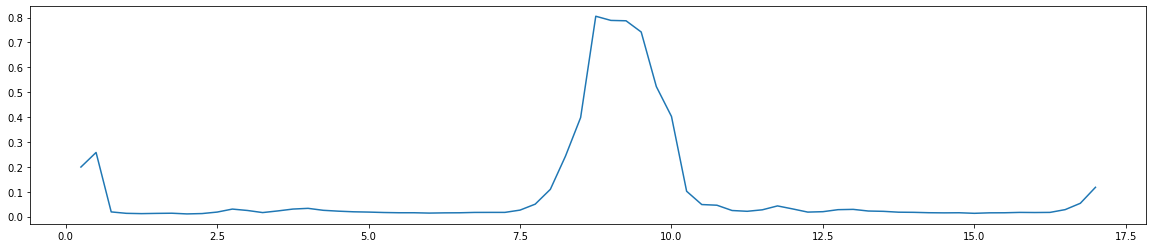

In [60]:
plt.figure(figsize=(20, 4))
plt.plot([ind/16000 for ind in indices[1:]], preds)
plt.show()